# Dpi Setting

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


### Dependencies

### Python

In [8]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [9]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [10]:
from rpy2.robjects.packages import importr


In [11]:
%load_ext rpy2.ipython

### R

In [12]:
%%R

if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

Loading required package: WaveSampling
Loading required package: Matrix
Loading required package: sampling
Loading required package: BalancedSampling
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


### Imports

In [13]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

/home/divar/projects/geometric-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

### Scores in R

In [14]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[0][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

# Handpicked Cases

## Linear 1D

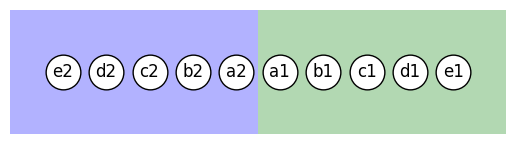

   Sample   # Density Voronai  Moran Local Balance
0   ai aj   1    0.14     0.0  -0.25          0.49
1   ai bi   2    0.14    0.04  -0.06          0.55
2   ai bj   2    0.11    0.04  -0.17          0.39
3   ai ci   2    0.11    0.04    0.0          0.52
4   ai cj   2    0.07    0.04  -0.79          0.36
5   ai di   2    0.07    0.16  -0.24          0.59
6   ai dj   2    0.02    0.16  -0.84          0.47
7   ai ei   2    0.02    0.25   -0.2          0.71
8   ai ej   2     0.0    0.16   -1.0          0.58
9   bi bj   1    0.07     0.0  -0.79          0.25
10  bi ci   2    0.14    0.16   0.06          0.69
11  bi cj   2    0.02    0.01  -0.84          0.18
12  bi di   2    0.11    0.36   0.13          0.76
13  bi dj   2     0.0    0.04   -1.0          0.28
14  bi ei   2    0.07    0.36  -0.13          0.85
15  bi ej   2    0.03    0.04  -0.76          0.42
16  ci cj   1     0.0     0.0   -1.0           0.0
17  ci di   2    0.14    0.36   0.19          0.89
18  ci dj   2    0.03    0.01  

In [126]:
points = {
    (0.35,): "a1",
    (-0.35,): "a2",
    (1.05,): "b1",
    (-1.05,): "b2",
    (1.75,): "c1",
    (-1.75,): "c2",
    (2.45,): "d1",
    (-2.45,): "d2",
    (3.15,): "e1",
    (-3.15,): "e2",
}

N = len(points)
n = 2
split_size = 0.01
coords = np.array(list(points.keys()))
probs = rng.equal_probabilities(n, N)
fig, ax = plt.subplots()
for (x,), label in points.items():
    ax.plot(x, 0, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, 0, label, color="black", ha="center", va="center", fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")
ax.axis("off")
ax.axvspan(0, 4, facecolor='green', alpha=0.3)
ax.axvspan(-4, 0, facecolor='blue', alpha=0.3)

plt.show()

dic_score = {}
for i, j in combinations(range(0, N), 2):
    i_label, j_label = points[tuple(coords[i])], points[tuple(coords[j])]
    if i_label[1] == j_label[1]:
        identifier = f"{i_label[0]}i {j_label[0]}i"
    else:
        identifier = f"{i_label[0]}i {j_label[0]}j"
    sample_idx = np.array([i, j])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx, split_size,)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 2)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.round(np.mean(all_scores, axis=0), 2)


result.append(
    np.concatenate([["Mean", len(all_scores)], overall_mean])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])
# print(df.to_latex(index=False))
print(df)

## 4 3x3

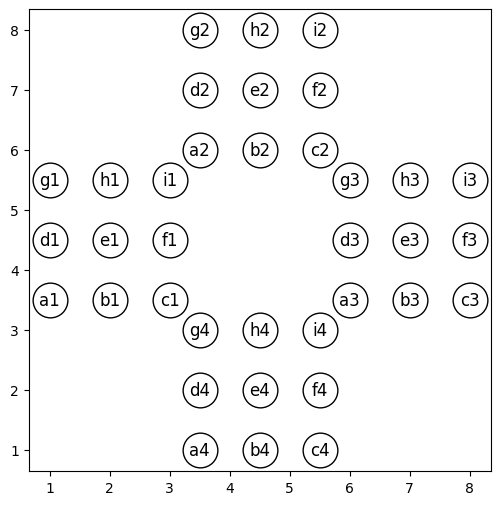

,Sample,Density,Voronai,Moran,Local Balance
0,e1 e2 e3 e4,0.00,0.00,-1.00,0.00
1,a1 a2 a3 a4,0.00,0.11,-0.59,0.43
2,d1 d2 d3 d4,0.00,0.02,-0.83,0.28
3,b1 d2 h3 f4,0.02,0.00,-0.75,0.19
4,f1 b2 d3 h4,0.33,0.00,-0.69,0.26
5,d1 h2 f3 b4,0.40,0.00,-0.50,0.26
6,a1 c1 g1 i1,0.34,0.56,0.38,0.84
7,b1 d1 f1 h1,0.48,0.56,0.52,0.79
8,h1 d2 b3 f4,0.03,0.00,-0.00,0.26


\begin{tabular}{llllll}
\toprule
 & Sample & Density & Voronai & Moran & Local Balance \\
\midrule
0 & e1 e2 e3 e4 & 0.00 & 0.00 & -1.00 & 0.00 \\
1 & a1 a2 a3 a4 & 0.00 & 0.11 & -0.59 & 0.43 \\
2 & d1 d2 d3 d4 & 0.00 & 0.02 & -0.83 & 0.28 \\
3 & b1 d2 h3 f4 & 0.02 & 0.00 & -0.75 & 0.19 \\
4 & f1 b2 d3 h4 & 0.33 & 0.00 & -0.69 & 0.26 \\
5 & d1 h2 f3 b4 & 0.40 & 0.00 & -0.50 & 0.26 \\
6 & a1 c1 g1 i1 & 0.34 & 0.56 & 0.38 & 0.84 \\
7 & b1 d1 f1 h1 & 0.48 & 0.56 & 0.52 & 0.79 \\
8 & h1 d2 b3 f4 & 0.03 & 0.00 & -0.00 & 0.26 \\
\bottomrule
\end{tabular}



In [127]:
samples = np.array([
    ["e1", "e2", "e3", "e4"],
    ["a1", "a2", "a3", "a4"],
    ["d1", "d2", "d3", "d4"],
    ["f4", "h3", "d2", "b1"],
    ["f1", "b2", "d3", "h4"],
    ["f3", "d1", "b4", "h2"],
    ["a1", "c1", "g1", "i1"],
    ["b1", "d1", "f1", "h1"],
    #### NEW Interstings
    "h1 d2 b3 f4".split(" "),
])

x3coords = rng.grid_coordinates((3, 2)) * 2
x3probs = rng.equal_probabilities(1, 9)

left = x3coords.copy()
right = x3coords.copy()
up = x3coords.copy()
down = x3coords.copy()

left_labels = [chr(ord('a') + i) + '1' for i in range(9)]
right_labels = [chr(ord('a') + i) + '3' for i in range(9)]
up_labels = [chr(ord('a') + i) + '2' for i in range(9)]
down_labels = [chr(ord('a') + i) + '4' for i in range(9)]

####### TEST
import itertools
# samples = np.array([
#     [l, u, r, d]
#     for l, u, r, d in itertools.product(left_labels, up_labels, right_labels, down_labels)
# ])
#######

left[:, 0] += 1
left[:, 1] += 3.5
right[:, 0] += 6
right[:, 1] += 3.5
up[:, 0] += 3.5
up[:, 1] += 6
down[:, 0] += 3.5
down[:, 1] += 1


coords = np.vstack([left, right, up, down])
probs = np.concatenate([x3probs, x3probs, x3probs, x3probs])
labels = np.concatenate([left_labels, right_labels, up_labels, down_labels])
label_to_idx = {l: idx for idx, (c, l) in enumerate(zip(coords, labels))}
assert len(probs) == len(coords) == len(labels)

N = len(coords)
n = 4
split_size = .01
points = {}
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
for (x, y), label in zip(coords, labels):
    points[label] = (x, y)
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', label=1, markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

plt.show()

results = []
for sample in samples:
    sample_idx = np.array([label_to_idx[s] for s in sample])
    identifier = " ".join(sorted(sample, key=lambda x: x[1]))
    s = scores(coords, probs, n, N, sample_idx, split_size,)
    s_formatted = [f"{num:.2f}" for num in s]  # Corrected line
    results.append([identifier] + s_formatted)

df = pd.DataFrame(results, columns=["Sample", "Density", "Voronai", "Moran", "Local Balance"])
display(df)
print(df.to_latex())


## Rotating

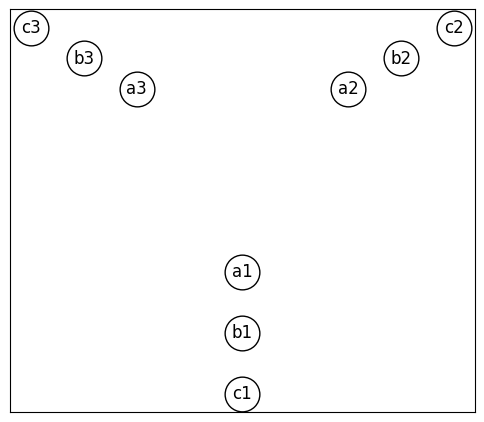

,Sample,#,Density,Voronai,Moran,Local Balance
0,aaa,1,0.56,0.0,-1.0,0.263
1,aab,3,0.3,0.0,-1.0,0.214
2,aac,3,0.141,0.0,-1.0,0.263
3,abb,3,0.101,0.0,-1.0,0.152
4,abc,6,0.045,0.0,-1.0,0.214
5,acc,3,0.039,0.0,-1.0,0.263
6,bbb,1,0.0,0.0,-1.0,0.0
7,bbc,3,0.067,0.0,-1.0,0.152
8,bcc,3,0.161,0.0,-1.0,0.214
9,ccc,1,0.223,0.0,-1.0,0.263


In [ ]:
def rotate_point(p, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.array([
        p[0] * cost - p[1] * sint,
        p[0] * sint + p[1] * cost
    ])

def rotate_matrix(matrix, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.apply_along_axis(rotate_point, 1, matrix, t, cost, sint)

template = np.array([
    [0.0, -0.5],
    [0.0, -1],
    [0.0, -1.5]
])
template = np.array([
    [0.0, -2],
    [0.0, -3],
    [0.0, -4]
])

angles = np.arange(0, 3) * (2.0 * np.pi / 3.0)
pop = np.vstack([rotate_matrix(template, angle) for angle in angles])

all_points = pop
labels = ["a1", "b1", "c1", "a2", "b2", "c2", "a3", "b3", "c3"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")

for (x, y), label in zip(all_points, labels):
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[1][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value
N = len(all_points)
n = 3
split_size=0.01
coords = np.array(all_points)
probs = rng.equal_probabilities(n, N)

from itertools import combinations, combinations_with_replacement

dic_score = {}
for i, j, k in combinations(range(0, N), 3):
    i_label, j_label, k_label = labels[i], labels[j], labels[k]
    ids = list(sorted([i_label[0], j_label[0], k_label[0]]))
    identifier = "".join(ids)

    if len(set([i_label[1], j_label[1], k_label[1]])) != n:
      continue

    sample_idx = np.array([i, j, k])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx, split_size)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 3)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.mean(all_scores, axis=0)


result.append(
    np.concatenate([["Mean", len(all_scores)], np.round(overall_mean, 2)])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])

display(df)
# print(df.to_latex())

# Simulations

### Methods

In [15]:
def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    return gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=n_zones, tolerance=2, split_size=0.001).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
        mask <- UPmaxentropy(probs)
        """
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

    return np.array(samples)


def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx


def find_samples(coords, probs, n, num_samples):
    return {
        "K-Means (1, 1)": k_means_samples(coords, probs, n, num_samples, (1, 1)),
        "K-Means (2, 2)": k_means_samples(coords, probs, n, num_samples, (2, 2)),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
    }

### Plots

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# --- SEEDING for reproducibility ---
np.random.seed(42)

# --- PARAMS ---
n = 4
n_clusters = n                         # Target sample size
grid_size = 20                  # For grid, grid_size^2 points → 400 total
num_clusters = 5               # For clustered
cluster_std = 0.05
swiss_csv = '/home/divar/projects/geometric-sampling/swiss.csv'
swiss_shp = '/home/divar/Downloads/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'

# -- You must define/provide these based on your project --
# rng.grid_coordinates(shape), rng.random_coordinates(shape), rng.cluster_coordinates, etc.
# rng.equal_probabilities(n, N), rng.unequal_probabilities(n, N)
# inclusion_probabilities()
# gs.sampling.KMeansSpatialSamplingSimple  # for making pop object with plot()

# --- 1. Setup holders for all coordinates/probs/populations ---
populations = {}
probabilities = {}
pop_objs = {}

# --- 2. REGULAR GRID ---
coords_grid = rng.grid_coordinates((grid_size, 2))
coords_grid = coords_grid[np.lexsort((coords_grid[:, 1], coords_grid[:, 0]))]
N_grid = coords_grid.shape[0]
probs_grid_eq = rng.equal_probabilities(n, N_grid)
probs_grid_uneq = np.sort(rng.unequal_probabilities(n, N_grid))

populations['grid'] = coords_grid
probabilities['grid_eq'] = probs_grid_eq
probabilities['grid_uneq'] = probs_grid_uneq

# --- 3. RANDOM ---
coords_rand = rng.random_coordinates((N_grid, 2))
coords_rand = coords_rand[np.lexsort((coords_rand[:, 1], coords_rand[:, 0]))]
probs_rand_eq = rng.equal_probabilities(n, N_grid)
probs_rand_uneq = np.sort(rng.unequal_probabilities(n, N_grid))

populations['random'] = coords_rand
probabilities['random_eq'] = probs_rand_eq
probabilities['random_uneq'] = probs_rand_uneq

# --- 4. CLUSTERED ---
coords_clust = rng.cluster_coordinates(num_clusters, cluster_std, (N_grid, 2))
coords_clust = coords_clust[np.lexsort((coords_clust[:, 1], coords_clust[:, 0]))]
probs_clust_eq = rng.equal_probabilities(n, N_grid)
probs_clust_uneq = np.sort(rng.unequal_probabilities(n, N_grid))

populations['clust'] = coords_clust
probabilities['clust_eq'] = probs_clust_eq
probabilities['clust_uneq'] = probs_clust_uneq

# --- 5. SWISS ---
swiss_df = pd.read_csv(swiss_csv)
coords_swiss = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
N_swiss = coords_swiss.shape[0]
area = swiss_df['AREA'].clip(1, 150)
probs_swiss_eq = rng.equal_probabilities(n, N_swiss)
probs_swiss_uneq = inclusion_probabilities(area, n)

populations['swiss'] = coords_swiss
probabilities['swiss_eq'] = probs_swiss_eq
probabilities['swiss_uneq'] = probs_swiss_uneq

# ---- 6. Create pop objects (e.g. for your plotting/class methods, using equal probs for now) ----
for key, coords in populations.items():
    if key == 'swiss':
        hard = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probabilities[f'{key}_eq'], n=n, n_zones=(2, 2), tolerance=3, split_size=.001)
        pop_objs[f'{key}_eq'] = hard.popu
        hard = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probabilities[f'{key}_uneq'], n=n, n_zones=(2, 2), tolerance=3, split_size=.001)
        pop_objs[f'{key}_uneq'] = hard.popu
    else:
        hard = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probabilities[f'{key}_eq'], n=n, n_zones=(2, 2), tolerance=3, split_size=.001)
        pop_objs[f'{key}_eq'] = hard.popu
        hard = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probabilities[f'{key}_uneq'], n=n, n_zones=(2, 2), tolerance=3, split_size=.0001)
        pop_objs[f'{key}_uneq'] = hard.popu

# ---- 7. Load Swiss map outline for background ----
world = gpd.read_file(swiss_shp)
swiss_map = world[world['ADMIN'] == 'Switzerland'].to_crs(epsg=2056)

print(N_grid)

# ==== Populations/coordinat/probs are stored in 'populations' and 'probabilities' dicts for later use ====

400


In [247]:
autumn_cmap = plt.get_cmap('autumn')
plasma_cmap = plt.get_cmap('plasma')

def get_autumn_colors(n_clusters):
    """Returns n_clusters colors from the autumn colormap."""
    colors = autumn_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

def get_plasma_colors(n_clusters):
    """Returns n_clusters colors from the plasma colormap."""
    colors = plasma_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

# Example usage:
n_clusters = n
import matplotlib.pyplot as plt
import numpy as np

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(mc.to_rgb(c))
    white = np.array([1, 1, 1])
    return tuple((1 - amount) * c + amount * white)

n_clusters = n
base_colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
light_colors = [lighten_color(col, 0.5) for col in base_colors]

autumn_colors = get_autumn_colors(n_clusters)
plasma_colors = get_plasma_colors(n_clusters)
plasma_colors = light_colors

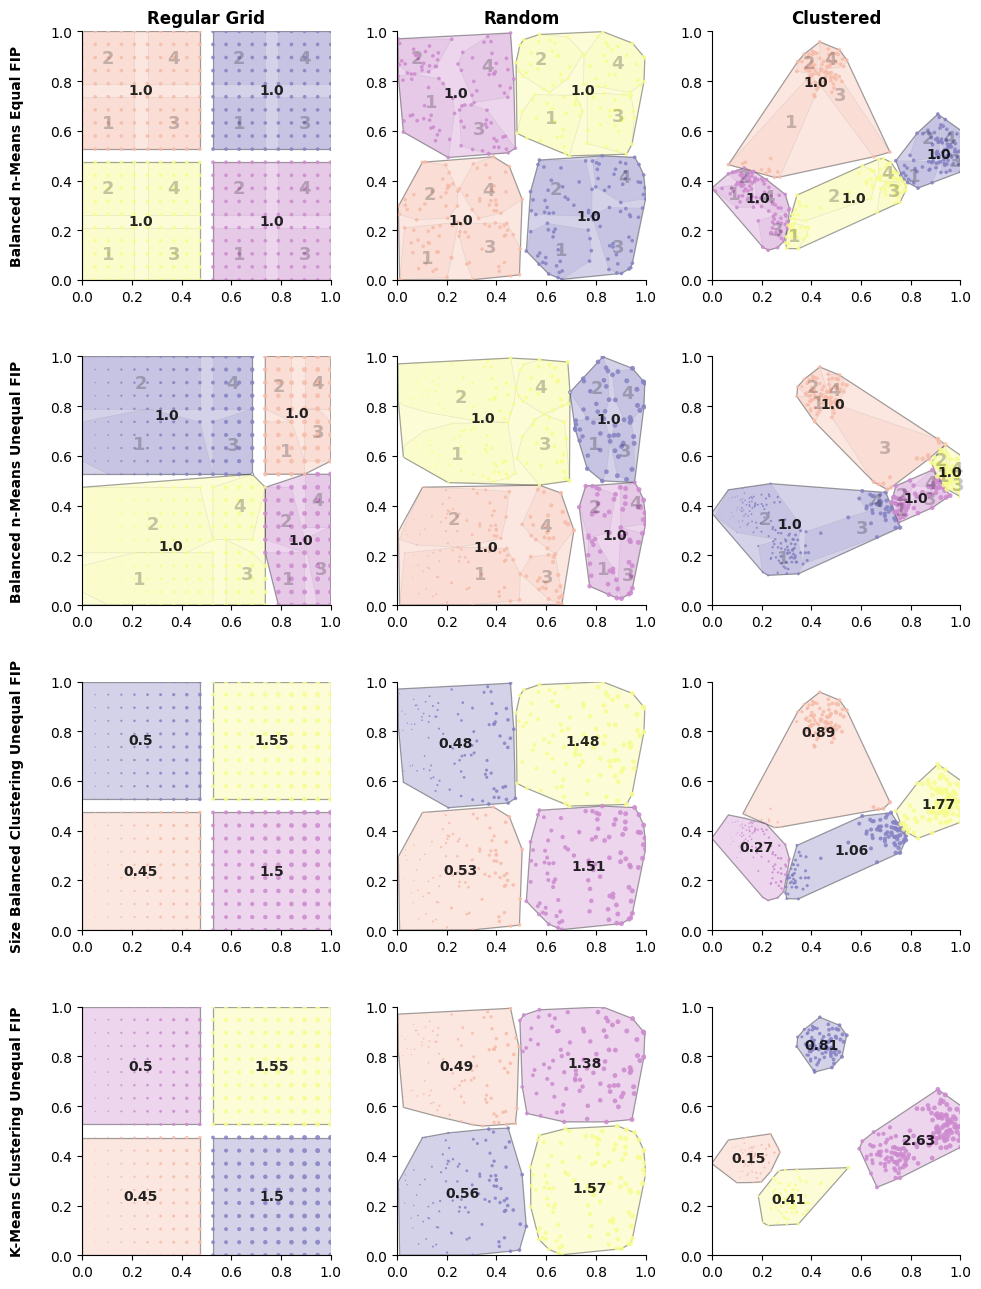

In [249]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull, QhullError
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained

n_clusters = n  # Change as needed
pop_titles = ['Regular Grid', 'Random', 'Clustered']
row_labels = [
    "Balanced n-Means Equal FIP",
    "Balanced n-Means Unequal FIP",
    "Size Balanced Clustering Unequal FIP",
    "K-Means Clustering Unequal FIP",
]
models = ['grid', 'random', 'clust']

def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    """Plot convex hull safely. Always returns (ax, hull or None)."""
    if len(points) < 3:
        return ax, None
    try:
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
            zorder=1
        )
        ax.add_patch(polygon)
        return ax, hull
    except QhullError:
        # Can't make hull, skip
        return ax, None

# Patch into PopulationSimple if needed!
import types
try:
    pop_objs['grid_eq'].plot_convex_hull = plot_convex_hull
except Exception:
    pass

fig, axes = plt.subplots(4, 3, figsize=(10, 13))

for col, model in enumerate(models):
    # ----------- 1st Row: Balanced n-Means Equal FIP -------------
    ax = axes[0, col]
    pops_eq = pop_objs[f'{model}_eq']
    # Ensure robust hull: monkeypatch into PopulationSimple if needed
    pops_eq.plot_convex_hull = plot_convex_hull
    # Defensive centroid calc for zones (example must be in class too)
    def safe_mean_zone(zone_points, hull):
        pts = zone_points if hull is None else zone_points[hull.vertices]
        return np.mean(pts, axis=0) if len(pts) > 0 else np.array([np.nan, np.nan])
    try:
        pops_eq.plot(ax=ax)
    except Exception as e:
        print(f"Error plotting {model}_eq: {e}")
    ax.set_title(pop_titles[col], fontsize=12, fontweight='bold')

    # ----------- 2nd Row: Balanced n-Means Unequal FIP -----------
    ax = axes[1, col]
    pops_uneq = pop_objs[f'{model}_uneq']
    pops_uneq.plot_convex_hull = plot_convex_hull
    try:
        pops_uneq.plot(ax=ax)
    except Exception as e:
        print(f"Error plotting {model}_uneq: {e}")
    ax.set_title("")

    # ----------- 3rd Row: Size-Balanced KMeans Clustering --------
    ax = axes[2, col]
    X = pops_uneq.coords
    probs = pops_uneq.probs
    kmeans_const = KMeansConstrained(
        n_clusters=n_clusters,
        size_min=int(X.shape[0] / n_clusters),
        size_max=int(np.ceil(X.shape[0] / n_clusters)),
        random_state=1
    ).fit(X)
    colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
    colors = light_colors
    for clust in range(n_clusters):
        idx = (kmeans_const.labels_ == clust)
        cluster_points = X[idx]
        cluster_color = colors[clust]
        # Draw convex hull
        if np.sum(idx) >= 3:
            _, hull = plot_convex_hull(cluster_points, ax,
                                    color=cluster_color, alpha=0.36, edge_color='black', line_width=0.9)
        # Draw points
        ax.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            color=cluster_color,
            edgecolors="none",
            s=probs[idx] * 700,
            alpha=0.88,
            zorder=2,
        )
        prob_sum = round(probs[idx].sum(), 2)
        # Draw cluster sum
        center = cluster_points.mean(axis=0) if len(cluster_points)>0 else np.array([np.nan,np.nan])
        ax.text(center[0], center[1], f"{prob_sum}",
                color="black", fontsize=10, weight="bold", alpha=0.85,
                ha="center", va="center", zorder=3)
    ax.set_title("")

    # ----------- 4th Row: KMeans Clustering ----------------------
    ax = axes[3, col]
    kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(X)
    for clust in range(n_clusters):
        idx = (kmeans.labels_ == clust)
        cluster_points = X[idx]
        cluster_color = colors[clust]
        # Draw convex hull
        if np.sum(idx) >= 3:
            _, hull = plot_convex_hull(cluster_points, ax,
                                    color=cluster_color, alpha=0.36, edge_color='black', line_width=0.9)
        # Draw points
        ax.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            color=cluster_color,
            edgecolors="none",
            s=probs[idx] * 700,
            alpha=0.88,
            zorder=2,
        )
        prob_sum = round(probs[idx].sum(), 2)
        # Draw cluster sum
        center = cluster_points.mean(axis=0) if len(cluster_points)>0 else np.array([np.nan,np.nan])
        ax.text(center[0], center[1],f"{prob_sum}",
                color="black", fontsize=10, weight="bold", alpha=0.85,
                ha="center", va="center", zorder=3)
    ax.set_title("")

# --------- Formatting -----------
for ax in axes.flatten():
    ax.set_aspect("equal")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(.0, 1)
    ax.set_ylim(.0, 1)
    # Keep left and bottom spines visible

# -------- Row Annotations -------
for row in range(4):
    axes[row,0].annotate(row_labels[row],
                         xy=(0, 0.5),
                         xytext=(-axes[row,0].yaxis.labelpad-11, 0),
                         xycoords=axes[row,0].yaxis.label,
                         textcoords='offset points',
                         size=10, ha='right', va='center', fontweight='bold', rotation=90)

plt.tight_layout()
plt.show()

### Swiss

In [ ]:
import matplotlib.pyplot as plt

pop_titles = ['Regular Grid', 'Random', 'Clustered', 'Swiss']
col_labels = ["Switzerland Amphibians, Balanced n-Means Equal FIP", "Switzerland Amphibians, Balanced n-Means Unequal FIP",]

for i, model in enumerate(['swiss']):  # Or use more models
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Equal inclusion (left)
    ax = axes[0]
    if model == 'swiss':
        swiss_map.plot(ax=ax, color="white", edgecolor="black", linewidth=1.0, zorder=0)
    pop_objs[f'{model}_eq'].plot(ax=ax)
    ax.set_title(col_labels[0], fontsize=15, fontweight='bold')
    ax.set_aspect("equal")

    # Unequal inclusion (right)
    ax = axes[1]
    if model == 'swiss':
        swiss_map.plot(ax=ax, color="white", edgecolor="black", linewidth=1.0, zorder=0)
    pop_objs[f'{model}_uneq'].plot(ax=ax)
    ax.set_title(col_labels[1], fontsize=15, fontweight='bold')
    ax.set_ylabel("")
    ax.set_aspect("equal")

    # Only show left and bottom spines (axes)
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Left/bottom stays visible for axes labels/ticks

    # Tighten space
    plt.tight_layout(rect=[0, 0.01, 1, 0.93])
    plt.subplots_adjust(wspace=0.06)  # Narrow gap between plots
    
    # Suptitle close to panels
    #fig.suptitle("Swiss Population", fontsize=15, fontweight='bold', y=0.85)

    plt.show()

#### Swiss sampling

In [ ]:
swiss_df = pd.read_csv('/home/divar/projects/geometric-sampling/swiss.csv')
coords = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
swiss_area_cliped = swiss_df['AREA'].clip(lower=1, upper=150)
N = len(coords)

probs = inclusion_probabilities(swiss_area_cliped, n)


### Gathering Data

In [ ]:
import pandas as pd
import os

folder = "data_samples"
os.makedirs(folder, exist_ok=True)

#   # diactivated to not overwrite some new results!
# for name, pop in pop_objs.items():
#     # Assuming pop.coords shape (N,2), pop.probs shape (N,)
#     df = pd.DataFrame(pop.coords, columns=["x", "y"])
#     df["prob"] = pop.probs
#     filename = f"{name}.csv"
#     df.to_csv(os.path.join(folder, filename), index=False)
#     print(f"Saved {filename}")

In [ ]:
df_coord_probs = pd.read_csv("data_samples/grid_eq.csv")
coords = df_coord_probs[["x", "y"]].values
probs = df_coord_probs["prob"].values

In [16]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
folder = "data_samples"
os.makedirs(folder, exist_ok=True)
all_coords = []
all_probs = []
names = [
    "clust_eq", "clust_uneq",
    "grid_eq", "grid_uneq",
    "random_eq", "random_uneq"
]
names = [
    "swiss_eq", "swiss_uneq",
    ]
#names = ["random_uneq"]
for name in names:
    df = pd.read_csv(f"data_samples/{name}.csv")
    coords = df[["x", "y"]].values
    probs = df["prob"].values
    all_coords.append(coords)
    all_probs.append(probs)

sample_cnt = 1000
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]

for coords, probs, name in zip(all_coords, all_probs, names):
    n = int(np.round(np.sum(probs)))
    N =len(probs)
    # Any code for one set, put here:
    sample_methods = find_samples(coords, probs, n, sample_cnt)
    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    rows = np.array([
    [method, *scores(coords, probs, n, N, s, density_measure)]
    for method, samples in sample_methods.items()
    if samples is not None  # <----- add this
    for s in tqdm(samples, total=sample_cnt)
])
    df = pd.DataFrame(rows, columns=columns)
    df = df.astype({
        "Density": float,
        "Voronoi": float,
        "Moran": float,
        "Local Balance": float
    })
    filename = os.path.join(folder, f"results_{name}.csv")
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

/home/divar/projects/geometric-sampling/geometric_sampling/sampling/popu.py:148: RuntimeWarning: divide by zero encountered in scalar divide
  probs_stabled *= 1 / (np.sum(probs_stabled) * np.prod(self.n_zones))
/home/divar/projects/geometric-sampling/geometric_sampling/sampling/popu.py:148: RuntimeWarning: invalid value encountered in multiply
  probs_stabled *= 1 / (np.sum(probs_stabled) * np.prod(self.n_zones))
100%|██████████| 1000/1000 [45:39<00:00,  2.74s/it]


Saved: data_samples/results_swiss_eq.csv


100%|██████████| 1000/1000 [2:49:08<00:00, 10.15s/it]     

Saved: data_samples/results_swiss_uneq.csv


In [17]:
print(len(probs))
print(sum(probs))

959
3.9999999999999347


In [48]:
results_dict = {}

for name in names:
    df = pd.read_csv(os.path.join(folder, f"results_{name}.csv"))
    results_dict[name] = df

## Results

In [39]:
df = results_dict["grid_eq"]

In [40]:
%load_ext autoreload
%autoreload 2
import geometric_sampling as gs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Tables

Means

Describe

In [41]:
#df.groupby("Method").std()
#df.groupby("Method").mean()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df.groupby("Method").describe())

Density                                            \
                 count          mean           std           min   
Method                                                             
K-Means (1, 1)     5.0 -8.243072e-16  6.757714e-17 -8.575073e-16   
K-Means (2, 2)     5.0 -7.918254e-16  7.943882e-17 -8.632342e-16   
Local Pivotal      5.0 -1.908042e-01  2.005944e-01 -3.909999e-01   
Random             5.0 -2.143390e-01  3.898654e-01 -6.306073e-01   
UPmaxentropy       5.0 -3.773028e-01  2.155575e-01 -7.270992e-01   

                                                                        \
                         25%           50%           75%           max   
Method                                                                   
K-Means (1, 1) -8.575073e-16 -8.528520e-16 -8.501153e-16 -7.035541e-16   
K-Means (2, 2) -8.435283e-16 -8.417510e-16 -7.070593e-16 -7.035541e-16   
Local Pivotal  -3.362569e-01 -2.346140e-01 -1.008596e-01  1.087094e-01   
Random         -5.830634e-01 -1.872128e-01  9.101805e-02  2.381702e-01   
UPmaxentropy   -4.213662e-01 -3.157500e-01 -2.469151e-01 -1.753835e-01   

               Voronoi                                                    \
                 count      mean       std       min       25%       50%   
Method                                                                     
K-Means (1, 1)     5.0  0.129015  0.101276  0.012525  0.063400  0.102563   
K-Means (2, 2)     5.0  0.171154  0.079376  0.049250  0.162900  0.171600   
Local Pivotal      5.0  0.099983  0.088553  0.007550  0.019013  0.107700   
Random             5.0  0.215792  0.221698  0.032300  0.054950  0.178312   
UPmaxentropy       5.0  0.314650  0.091820  0.215163  0.235525  0.328963   

                                   Moran                                \
                     75%       max count      mean       std       min   
Method                                                                   
K-Means (1, 1)  0.214525  0.252063   5.0 -0.221298  0.053646 -0.287469   
K-Means (2, 2)  0.205506  0.266513   5.0 -0.211112  0.040810 -0.265425   
Local Pivotal   0.147600  0.218050   5.0 -0.106575  0.036547 -0.149541   
Random          0.229550  0.583850   5.0 -0.089686  0.061531 -0.171857   
UPmaxentropy    0.352850  0.440750   5.0 -0.058093  0.049809 -0.118767   

                                                       Local Balance  \
                     25%       50%       75%       max         count   
Method                                                                 
K-Means (1, 1) -0.258744 -0.222936 -0.178376 -0.158962           5.0   
K-Means (2, 2) -0.223750 -0.222950 -0.184131 -0.159305           5.0   
Local Pivotal  -0.129624 -0.105564 -0.094705 -0.053440           5.0   
Random         -0.123572 -0.073720 -0.071102 -0.008179           5.0   
UPmaxentropy   -0.102349 -0.043344 -0.013161 -0.012844           5.0   

                                                                            \
                    mean       std       min       25%       50%       75%   
Method                                                                       
K-Means (1, 1)  0.385465  0.163570  0.155799  0.302032  0.393549  0.518861   
K-Means (2, 2)  0.430794  0.106319  0.265230  0.411866  0.433078  0.501395   
Local Pivotal   0.326949  0.108931  0.207518  0.226604  0.336332  0.410812   
Random          0.471855  0.134271  0.365651  0.397234  0.425932  0.468076   
UPmaxentropy    0.581434  0.075459  0.508016  0.537424  0.574487  0.581708   

                          
                     max  
Method                    
K-Means (1, 1)  0.557083  
K-Means (2, 2)  0.542399  
Local Pivotal   0.453481  
Random          0.702385  
UPmaxentropy    0.705535

### Plots

##### Color Pallet

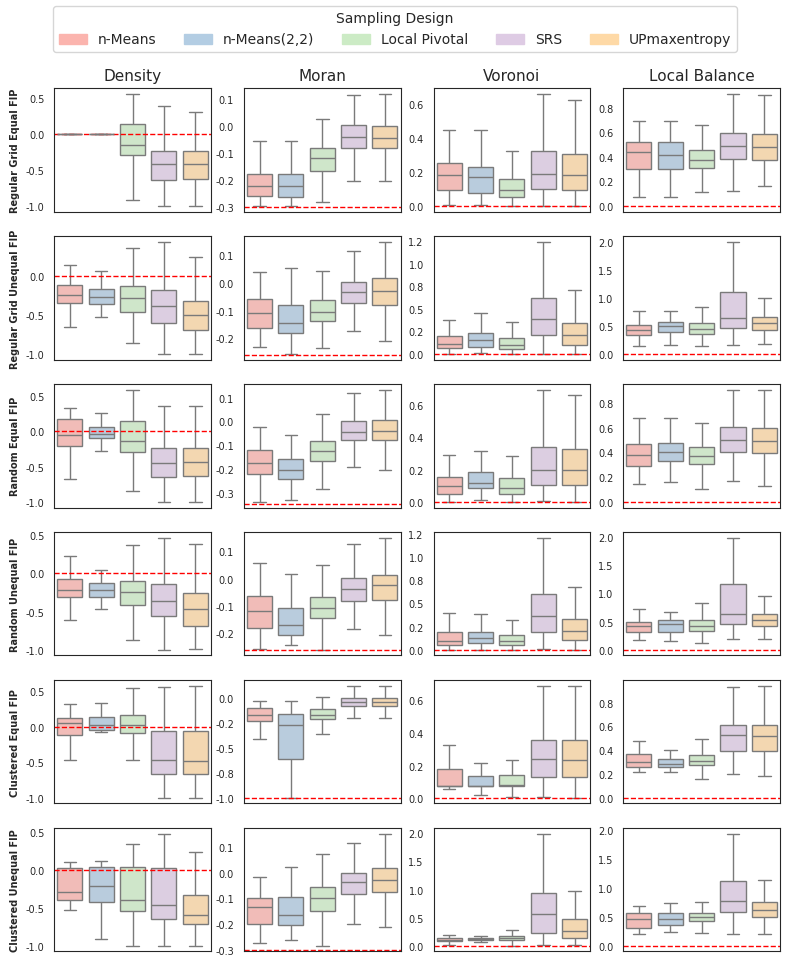

            Method   Density   Voronoi     Moran  Local Balance
0          n-Means  0.067150  0.111803 -0.074104       0.358764
1          n-Means -0.413749  0.062807 -0.097121       0.570009
2          n-Means -0.302285  0.118182 -0.196904       0.561215
3          n-Means -0.439773  0.068987 -0.118828       0.579531
4          n-Means -0.363454  0.089134 -0.146348       0.451394
...            ...       ...       ...       ...            ...
4995  UPmaxentropy -0.998797  0.112600  0.038374       0.727813
4996  UPmaxentropy  0.103808  0.128956 -0.143977       1.285376
4997  UPmaxentropy -0.634342  0.472614 -0.067616       0.704652
4998  UPmaxentropy -0.628966  0.382313  0.038164       0.794939
4999  UPmaxentropy -0.550270  0.104263 -0.002283       4.259062

[5000 rows x 5 columns]


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

# Folder and file info
method_order = ["n-Means", "n-Means(2,2)", "Local Pivotal", "SRS", "UPmaxentropy"]
results_folder = 'data_samples'
result_files = [
    # "results_grid_eq.csv",
    # "results_grid_uneq.csv",
    # "results_random_eq.csv",
    # "results_random_uneq.csv",
    # "results_clust_eq.csv",
    # "results_clust_uneq.csv",
    "results_swiss_eq.csv",
    "results_swiss_eq.csv",
]
pretty_names = {
    # "grid_eq": "Regular Grid Equal FIP",
    # "grid_uneq": "Regular Grid Unequal FIP",
    # "random_eq": "Random Equal FIP",
    # "random_uneq": "Random Unequal FIP",
    # "clust_eq": "Clustered Equal FIP",
    # "clust_uneq": "Clustered Unequal FIP",
    "swiss_eq": "Switzerland Equal FIP",
    "swiss_uneq": "Switzerland Unequal FIP",
}

# Use the new column for plotting (x or hue):
pop_names = [s.replace("results_", "").replace(".csv", "") for s in result_files]

# Read results into a dict
results_dict = {
    name: pd.read_csv(os.path.join(results_folder, fname))
    for name, fname in zip(pop_names, result_files)
}
# Mapping for nicer method names
method_name_mapping = {
    "K-Means (1, 1)": "n-Means",
    "K-Means (3, 3)": "n-Means(2,2)",
    "Local Pivotal": "Local Pivotal",
    "Random": "SRS",
    "UPmaxentropy": "UPmaxentropy"
}

# Apply the mapping to ALL dataframes in your results_dict
for df in results_dict.values():
    df["Method"] = df["Method"].map(method_name_mapping)

# OPTIONAL: Remove any 'Method Pretty' columns if you made them previously
for df in results_dict.values():
    if "Method Pretty" in df.columns:
        df.drop(columns=["Method Pretty"], inplace=True)
# Method palette for coloring
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel1", n_colors=len(all_methods))))

def remove_outliers(dataframe, column, IQR_coef=10, groupby_col=None):
    if groupby_col:
        def outlier_filter(group):
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - IQR_coef * IQR
            upper = Q3 + IQR_coef * IQR
            return group[(group[column] >= lower) & (group[column] <= upper)]
        return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
    else:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - IQR_coef * IQR
        upper = Q3 + IQR_coef * IQR
        return dataframe[(dataframe[column] >= lower) & (dataframe[column] <= upper)]

# Metrics
columns = [c for c in results_dict[pop_names[0]].columns if c != "Method"]
columns = [columns[i] for i in [0, 2, 1, 3]]

# Create 6x4 grid (6 populations, 4 metrics)
n_rows = len(pop_names)
n_cols = len(columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 1.7*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_pop[df_pop[metric] < 2],  # <--- Filter here!
#            data=df_pop, #remove_outliers(df_pop, metric, IQR_coef=10, groupby_col="Method"),
            hue="Method",  # always assign hue for consistent handles
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False
        )
        #ax.grid(True)
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=11)
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=7)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        if not (row_idx == 0 and col_idx == 0):
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
        ax.tick_params(axis='y', labelsize=7)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))  # 2 decimals
        if metric in ['Density', 'Voronoi', 'Local Balance']:
            ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
        else:
            ax.axhline(y=min(df_pop['Moran']), color='red', linestyle='--', linewidth=1)
# ... rest of your code as above ...

# ----------- SHARED LEGEND BLOCK (robust dummy plot method) -----------
fig_legend, ax_legend = plt.subplots()
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)

# NOTE: Only use x="Method", NOT hue!
sns.boxplot(
    x="Method",
    y=columns[0],
    data=df_concat,
    palette=method_palette,
    ax=ax_legend,
    showfliers=False
)
handles, labels = ax_legend.get_legend_handles_labels()

# If still empty, use get_xticklabels instead:
if all([h is None for h in handles]) or not handles:
    labels = [t.get_text() for t in ax_legend.get_xticklabels()]
    from matplotlib.patches import Patch
    handles = [Patch(color=method_palette[l]) for l in labels]

plt.close(fig_legend)
fig.legend(handles, labels, loc='upper center', ncol=len(all_methods), title="Sampling Design")
# ----------------------------------------------------------------------

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.21, hspace=0.2)
# fig.suptitle("All metrics for all populations", fontsize=16, y=1.01)
plt.show()
print(df)